# Behavioral summary

Quick and dirty summary of behavioral stability for figure 1-S1

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

np.seterr(all='raise');

Data location is /home/mer49/Workspace2/PPC_data/


In [2]:
# Use for LMS in this case? 
use = [(1,[1, 4, 5, 6, 7, 10, 14]),
    (3,[ 1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
    (4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]),
    (5,[6, 7, 8, 9, 10, 11, 12])]

## Get kinematics

In [3]:
from ppc_analysis import kininfo

a, ss = use[0]
k = [array([cat(extract_in_trial(k['get'](a,s),a,s)) for k in kininfo.values()]) for s in ss]

NSESSIONS = len(ss)
NKIN      = k[0].shape[0]
NLAG      = 50
LAGSPACE  = 1
NXVAL     = 10
REG       = 1e-9

Defined subroutines
Defined LMS algorithm


## Linear predictability, broken down by beahvioral variable

In [4]:

for kk in kininfo.keys():
    print(kk,kininfo[kk]['name'])
    for a, ss in use:
        print(a,ss)
        #k = [array([cat(extract_in_trial(k['get'](a,s),a,s)) for k in kininfo.values()]) for s in ss]
        k = [array([cat(extract_in_trial(k['get'](a,s),a,s)) for k in [kininfo[kk]]]) for s in ss]
        NSESSIONS = len(ss)
        NKIN      = k[0].shape[0]
        NLAG      = 53
        LAGSPACE  = 1
        NXVAL     = 10
        REG       = 1e-9
        BLOCKSIZE = 100
        
        tuse = None
        if kininfo[kk]['name'] in ('Y position','Y velocity'):
            ky  = [array([cat(extract_in_trial(get_y(a,s),a,s))]) for s in ss]
            ky  = cat(ky,axis=1).ravel()
            tuse = (ky>0.5)&(ky<3)
        if kininfo[kk]['name'] in ('X position','X velocity'):
            kx  = [array([cat(extract_in_trial(get_y(a,s),a,s))]) for s in ss]
            kx  = cat(kx,axis=1).ravel()
            tuse = abs(kx)>0.05
        
        khist  = cat([[make_lagged(ki,NLAG,LAGSPACE) for ki in kj] for kj in k],axis=2)
        khist  = khist.reshape(NKIN*NLAG,khist.shape[-1]).T
        khist  = add_constant(khist)
        khist  = zscore(khist ,axis=0)
        if not tuse is None:
            khist  = khist[tuse,:]
        
        labels = onehot(cat([ones(kj.shape[-1])*j for j,kj in enumerate(k)]))[1].T
        labels = zscore(labels,axis=0)
        if not tuse is None:
            labels = labels[tuse,:]
        
        NSAMP  = khist.shape[0]
        perm   = int32(block_shuffle(arange(NSAMP),BLOCKSIZE))
        khist  = khist[perm,...]
        labels = labels[perm,...]

        trainK,trainL,testK,testL = partition_data_for_crossvalidation(khist,labels,NXVAL)
        evars = []
        predicted = []
        for i in range(NXVAL):
            w    = reglstsq(trainK[i],trainL[i],REG)
            lhat = testK[i] @ w
            #print('  Block %d'%i,end=' ')
            evars.append(100*(1-rmse(testL[i],lhat)**2/var(testL[i])))
            predicted.append(100*mean(argmax(lhat,1)==argmax(testL[i],axis=1)))
        #print('  % explained variance',mean(evars))

        # Chance level
        perm2  = int32(block_shuffle(arange(NSAMP),BLOCKSIZE))
        labels = labels[perm2,...]
        trainK,trainL,testK,testL = partition_data_for_crossvalidation(khist,labels,NXVAL)
        chance = []
        for i in range(NXVAL):
            w    = reglstsq(trainK[i],trainL[i],REG)
            lhat = testK[i] @ w
            chance.append(100*mean(argmax(lhat,1)==argmax(testL[i],axis=1)))

        #print('  % accuracy',mean(predicted))
        #print('  Chance accuracy is:',mean(chance))
        print('  Above chance is %d%%'%(mean(predicted)-mean(chance)))


0 X position
1 [1, 4, 5, 6, 7, 10, 14]
  Above chance is 0%
3 [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
  Above chance is -1%
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Above chance is 0%
5 [6, 7, 8, 9, 10, 11, 12]
  Above chance is 0%
1 Y position
1 [1, 4, 5, 6, 7, 10, 14]
  Above chance is 15%
3 [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
  Above chance is 7%
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Above chance is 13%
5 [6, 7, 8, 9, 10, 11, 12]
  Above chance is 17%
2 X velocity
1 [1, 4, 5, 6, 7, 10, 14]
  Above chance is 0%
3 [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
  Above chance is 0%
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Above chance is 0%
5 [6, 7, 8, 9, 10, 11, 12]
  Above chance is 1%
3 Y velocity
1 [1, 4, 5, 6, 7, 10, 14]
  Above chance is 5%
3 [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
  Above chance is 7%
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

## Look for systematic changes in Y velocity

In [5]:
import statsmodels.api as sm
import warnings
import pprint
from IPython.display import display
pp = pprint.PrettyPrinter(indent=4)

import neurotools.stats.pvalues

NLAG      = 50
LAGSPACE  = 1
NXVAL     = 10
REG       = 1e-9
KIN       = 1

with warnings.catch_warnings():
    # Insufficient data for some tests, but we don't need
    # a detailed analysis, just p-value for linear trend
    warnings.filterwarnings("ignore", message="omni_normtest")
    warnings.filterwarnings("ignore", message="kurtosistest" )
    p_values = {}
    correlations = {}
    for a,ss in use:
        k = [array([cat(extract_in_trial(k['get'](a,s),a,s)) for k in kininfo.values()]) for s in ss]
        NSESSIONS = len(ss)
        NKIN      = k[0].shape[0]
        means       = array([mean(k[i],axis=1)  for i in range(NSESSIONS)])
        covariances = array([covariance(k[i].T) for i in range(NSESSIONS)])
        days = [daymap[a,s] for s in ss]
        axgrid = {}
        medians = []
        for i in range(NSESSIONS):
            kk = k[i][3,:]
            g  = k[i][1,:]
            kk = kk[(g>0.25)&(g<2.75)]
            medians.append(median(kk))
        key = (a,tuple(ss))
        mod = sm.OLS(zeromean(medians),zeromean(days))
        fii = mod.fit()
        display(fii.summary())
        rho,p = scipy.stats.pearsonr(days,medians)
        p_values[key] = p
        correlations[key] = rho

corrected = neurotools.stats.pvalues.correct_pvalues(p_values)
for key in correlations.keys():
    print(key,correlations[key],corrected[key])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.099
Model:                            OLS   Adj. R-squared (uncentered):             -0.051
Method:                 Least Squares   F-statistic:                             0.6588
Date:                Wed, 13 May 2020   Prob (F-statistic):                       0.448
Time:                        10:27:11   Log-Likelihood:                          15.343
No. Observations:                   7   AIC:                                     -28.69
Df Residuals:                       6   BIC:                                     -28.74
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0021      0.003      0.812      0.448      -0.004       0.008
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.449
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.082
Skew:                           1.315   Prob(JB):                        0.353
Kurtosis:                       3.466   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.111
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              2.374
Date:                Wed, 13 May 2020   Prob (F-statistic):                       0.140
Time:                        10:27:16   Log-Likelihood:                          34.009
No. Observations:                  20   AIC:                                     -66.02
Df Residuals:                      19   BIC:                                     -65.02
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0020      0.001     -1.541      0.140      -0.005       0.001
==============================================================================
Omnibus:                        0.086   Durbin-Watson:                   2.865
Prob(Omnibus):                  0.958   Jarque-Bera (JB):                0.312
Skew:                          -0.025   Prob(JB):                        0.855
Kurtosis:                       2.390   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.570
Method:                 Least Squares   F-statistic:                              16.94
Date:                Wed, 13 May 2020   Prob (F-statistic):                     0.00171
Time:                        10:27:20   Log-Likelihood:                          24.778
No. Observations:                  12   AIC:                                     -47.56
Df Residuals:                      11   BIC:                                     -47.07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0088      0.002     -4.115      0.002      -0.014      -0.004
==============================================================================
Omnibus:                       18.934   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.294
Skew:                          -1.972   Prob(JB):                     0.000787
Kurtosis:                       6.609   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.487
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              5.703
Date:                Wed, 13 May 2020   Prob (F-statistic):                      0.0542
Time:                        10:27:22   Log-Likelihood:                          14.330
No. Observations:                   7   AIC:                                     -26.66
Df Residuals:                       6   BIC:                                     -26.71
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0152      0.006      2.388      0.054      -0.000       0.031
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.386
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.331
Skew:                          -0.514   Prob(JB):                        0.847
Kurtosis:                       2.717   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(1, (1, 4, 5, 6, 7, 10, 14)) 0.31453418838711933 (0.49204674135195003, False)
(3, (1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)) -0.3332473330071971 (0.20141650717141305, False)
(4, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)) -0.7786213294089782 (0.01139331424427524, True)
(5, (6, 7, 8, 9, 10, 11, 12)) 0.6980793709696443 (0.16221784837989667, False)


## Measure Effect sizes

Differences are significant, but small. Effect sizes? 

Cohen's d

In [6]:
for ia,(a, ss) in enumerate(use):
    k = [array(\
               [cat(extract_in_trial(k['get'](a,s),a,s))\
                for k in kininfo.values()])\
         for s in ss]

    NSESSIONS = len(ss)
    NKIN      = k[0].shape[0]
    ess = {}
    for l in range(NKIN):
        for i in range(NSESSIONS):
            for j in range(NSESSIONS):
                if i>=j: continue
                x1,x2 = k[i][l,:],k[j][l,:]
                es = (mean(x1)-mean(x2))/std(cat([x1,x2]))
                ess[l,i,j]=es
    aess = abs(array(list(ess.values())))
    print(a,mean(aess))


1 0.09943929537698588
3 0.14264604759093477
4 0.13817695786063633
5 0.1650219430504463


# Plot

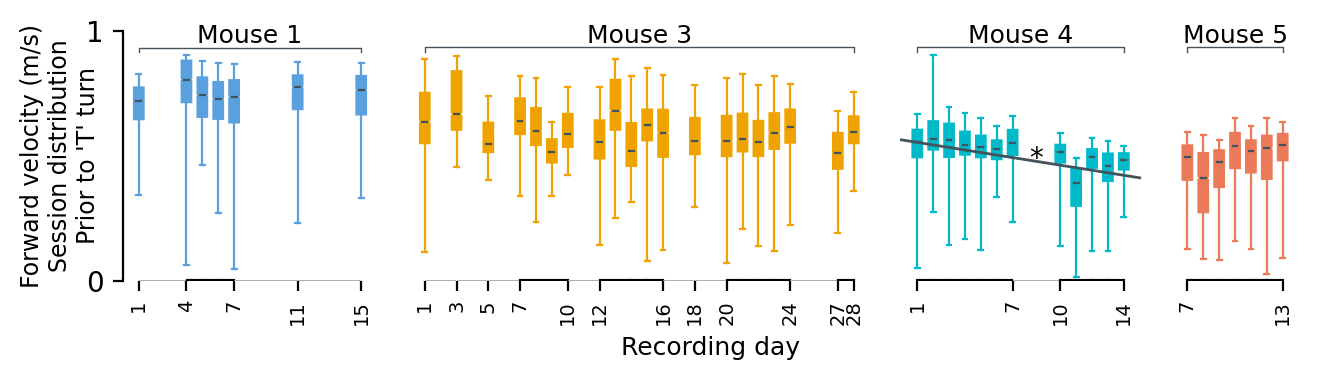

In [7]:
NLAG      = 50
LAGSPACE  = 1
NXVAL     = 10
REG       = 1e-9

# 6.69291 inch= A4 with 2cm margins
figure(figsize=(6.69291,2)) 

total_days = sum([len(ss) for a,ss in use])
OFFSET     = 1
ticks      = []
COLORS     = [AZURE,OCHRE,TURQUOISE,RUST]
for ia,(a,ss) in enumerate(use):
    k = [array([cat(extract_in_trial(k['get'](a,s),a,s)) for k in kininfo.values()]) for s in ss]
    nsess       = len(ss)
    NKIN        = k[0].shape[0]
    means       = array([mean(k[i],axis=1)  for i in range(nsess)])
    covariances = array([covariance(k[i].T) for i in range(nsess)])
    days  = [daymap[a,s] for s in ss]
    ndays = days[-1]-days[0]
    means = []
    previous = None
    for i in range(nsess):
        kk = k[i][3,:]
        g  = k[i][1,:]
        kk = kk[(g>0.25)&(g<2.75)]
        position = days[i]+OFFSET-days[0]
        d = days[i]
        colored_boxplot(kk,[position],COLORS[ia],linewidth=0.8,widths=0.6,notch=True,meanline=True)
        if i==0 or i==nsess-1 or abs(days[i-1]-d)>1 or (i+1<nsess and abs(days[i+1]-d)>1):
            ticks.append((position,str(d)))
        if abs(days[i-1]-d)==1:
            plot([position-1+0.07,position-0.07],[0,0],color='k',lw=1.5)
        elif i>0:
            plot([previous+0.07,position-0.07],[0,0],color=(0.65,)*3,lw=0.65)
        means.append(mean(kk))
        previous = position
    x0 = OFFSET
    x1 = OFFSET+ndays
    if ia==2: # Mouse 4 is significant
        m,b = np.polyfit(days,means,1)
        pad = 1
        xx = linspace(x0-pad,x1+pad,10)
        dd = linspace(days[0]-pad,days[-1]+pad,10)
        plot(xx,dd*m+b,color=BLACK,lw=1,zorder=inf)
        xtext = 7.5 + OFFSET
        ytext = 7.5*m+b
        text(xtext,ytext,'*',ha='center',va='center')
    simpleraxis()
    xlim(days[0]-1,days[-1]+1)
    xtext = (x1+x0)*0.5
    text(xtext,0.93,'Mouse %d'%(a),fontsize=9,ha='center',va='bottom')

    neurotools.graphics.plot.sigbar(x0,x1,0.9)
    OFFSET += ndays+4

ylim(0,1)
ylabel('Forward velocity (m/s)\nSession distribution\nPrior to \'T\' turn',fontsize=8.5)
xlabel('Recording day',fontsize=9)
xlim(0,ticks[-1][0]+1)
xticks(*list(zip(*ticks)))
yticks([0,1])
fudgey(5)

ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(7) 
    tick.label.set_rotation('vertical')
        
tight_layout()
savefigure('Fig1s1_behavior_boxplots_velocity',stamp=False)

# There isn't much structured variation in position data

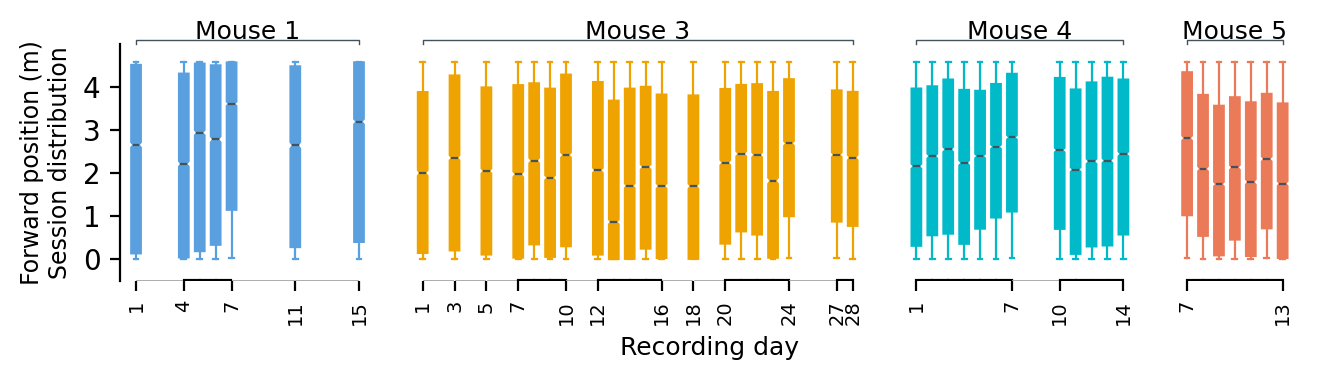

In [8]:
NLAG      = 50
LAGSPACE  = 1
NXVAL     = 10
REG       = 1e-9
ymin = -0.5

# 6.69291 inch= A4 with 2cm margins
figure(figsize=(6.69291,2)) 

total_days = sum([len(ss) for a,ss in use])
OFFSET     = 1
ticks      = []
COLORS     = [AZURE,OCHRE,TURQUOISE,RUST]
for ia,(a,ss) in enumerate(use):
    k = [array([cat(extract_in_trial(k['get'](a,s),a,s)) for k in kininfo.values()]) for s in ss]
    nsess       = len(ss)
    NKIN        = k[0].shape[0]
    means       = array([mean(k[i],axis=1)  for i in range(nsess)])
    covariances = array([covariance(k[i].T) for i in range(nsess)])
    days  = [daymap[a,s] for s in ss]
    ndays = days[-1]-days[0]
    means = []
    previous = None
    for i in range(nsess):
        kk = k[i][1,:]
        position = days[i]+OFFSET-days[0]
        d = days[i]
        colored_boxplot(kk,[position],COLORS[ia],linewidth=0.8,widths=0.6,notch=True,meanline=True)
        if i==0 or i==nsess-1 or abs(days[i-1]-d)>1 or (i+1<nsess and abs(days[i+1]-d)>1):
            ticks.append((position,str(d)))
        if abs(days[i-1]-d)==1:
            plot([position-1+0.07,position-0.07],[ymin,ymin],color='k',lw=1.5,zorder=-inf)
        elif i>0:
            plot([previous+0.07,position-0.07],[ymin,ymin],color=(0.65,)*3,lw=0.65,zorder=-inf)
        means.append(mean(kk))
        previous = position
    x0 = OFFSET
    x1 = OFFSET+ndays
    simpleraxis()
    xlim(days[0]-1,days[-1]+1)
    xtext = (x1+x0)*0.5
    text(xtext,5,'Mouse %d'%(a),fontsize=9,ha='center',va='bottom')
    neurotools.graphics.plot.sigbar(x0,x1,4.9)
    OFFSET += ndays+4

ylim(ymin,5)
ylabel('Forward position (m)\nSession distribution',fontsize=8.5)
xlabel('Recording day',fontsize=9)
xlim(0,ticks[-1][0]+1)
xticks(*list(zip(*ticks)))
yticks([0,1,2,3,4])

ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(7) 
    tick.label.set_rotation('vertical')
        
tight_layout()
savefigure('Fig1s1_behavior_boxplots_position',stamp=False)